#  Практика 6: Атака по переносу (Transfer Attack) на модели ИИ

##  Цель задания:

 Изучить концепцию атаки по переносу, где противоречивые примеры, созданные для одной модели,
 используются для атаки на другую модель. Это задание требует создания нескольких моделей,
 генерации противоречивых примеров для одной модели и проверки их на другой модели.

 ###  Задачи:
 1. Загрузить несколько моделей, обученных на датасете MNIST.
 2. Изучить теоретические основы атаки по переносу.
 3. Реализовать атаку FGSM на одну модель и проверить, как противоречивые примеры влияют на
 другую модель.
 4. Оценить точность обеих моделей на противоречивых примерах и проанализировать
 переносимость атак.

 Выполнил студент ББМО-02-23 Евдокимов А.М.

## Шаги выполнения

### Шаг 1: Загрузка и создание двух различных моделей

In [1]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.utils import to_categorical

In [2]:
# Загрузка данных MNIST
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
# Нормализация данных
train_images = train_images / 255.0
test_images = test_images / 255.0
# Преобразование меток в one-hot encoding
train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [8]:
# Модель 1: Простая полносвязная нейронная сеть
model1 = Sequential([
    Flatten(input_shape=(28, 28)),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')
])
 # Компиляция модели
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# Обучение модели
model1.fit(train_images, train_labels, epochs=5)
# Сохранение модели
model1.save('mnist_model1.h5')

Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.8745 - loss: 0.4379
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.9651 - loss: 0.1190
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9762 - loss: 0.0790
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.9828 - loss: 0.0550
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9869 - loss: 0.0421


In [9]:
test_loss, test_acc = model1.evaluate(test_images, test_labels)
print(f'Test accuracy on clean images: {test_acc}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9735 - loss: 0.0839
Test accuracy on clean images: 0.9764000177383423


In [11]:
 #Модель 2: Свёрточная нейронная сеть (CNN)
model2 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')
])
# Компиляция модели
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=
 ['accuracy'])
# Обучение модели
model2.fit(train_images, train_labels, epochs=5)
# Сохранение модели
model2.save('mnist_model2.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 42s 22ms/step - accuracy: 0.9151 - loss: 0.2903
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 41s 22ms/step - accuracy: 0.9849 - loss: 0.0502
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 41s 22ms/step - accuracy: 0.9909 - loss: 0.0290
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 41s 22ms/step - accuracy: 0.9940 - loss: 0.0184
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 82s 22ms/step - accuracy: 0.9966 - loss: 0.0111


In [12]:
test_loss, test_acc = model2.evaluate(test_images, test_labels)
print(f'Test accuracy on clean images: {test_acc}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9814 - loss: 0.0588
Test accuracy on clean images: 0.9848999977111816


### Шаг 2: Теория атаки по переносу

Атака по переносу — это метод, при котором противоречивые примеры, созданные для одной
 модели, применяются к другой модели. Это возможно, потому что модели часто имеют схожие
 слабости и могут совершать одинаковые ошибки на определенных данных, даже если они обучены
 на разных архитектурах.
 В этом задании мы создадим противоречивые примеры для первой модели с помощью FGSM и
 затем проверим, насколько эти примеры могут атаковать вторую модель.

### Шаг 3: Реализация атаки FGSM на первую модель

 Мы применим атаку FGSM (Fast Gradient Sign Method) к первой модели, чтобы создать противоречивые примеры

In [42]:
import tensorflow as tf
import numpy as np

# FGSM-атака
def fgsm_attack(image, epsilon, gradient):
    perturbed_image = image + epsilon * tf.sign(gradient)
    perturbed_image = tf.clip_by_value(perturbed_image, 0, 1)  # Ограничение значений в [0, 1]
    return perturbed_image

# Генерация противоречивых примеров
def generate_fgsm_adversarial(model, images, labels, epsilon):
    adversarial_images = []
    for i in range(len(images)):
        # Подготовка данных
        image = tf.convert_to_tensor(images[i].reshape(1, 28, 28, 1), dtype=tf.float32)
        label = tf.convert_to_tensor(labels[i].reshape(1, -1), dtype=tf.float32)

        with tf.GradientTape() as tape:
            tape.watch(image)
            prediction = model(image)
            loss = tf.keras.losses.categorical_crossentropy(label, prediction)

        # Вычисление градиента
        gradient = tape.gradient(loss, image)
        adv_image = fgsm_attack(image, epsilon, gradient)
        adversarial_images.append(adv_image.numpy().reshape(28, 28))

    return np.array(adversarial_images)

# Генерация противоречивых примеров
epsilon = 0.1
adversarial_images_model1 = generate_fgsm_adversarial(model1, test_images, test_labels, epsilon)


Визуализация

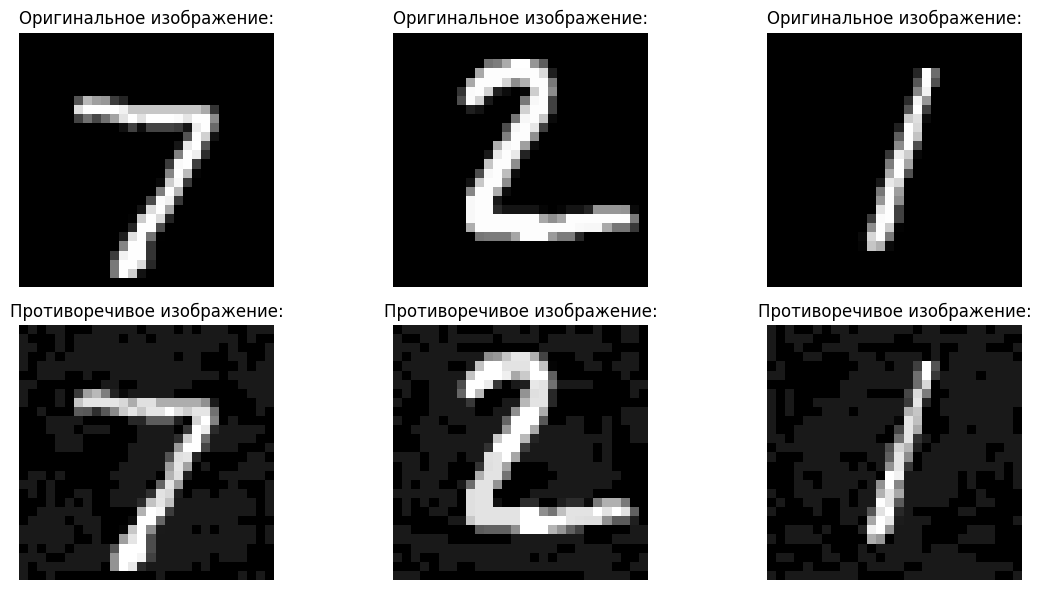

In [43]:
import matplotlib.pyplot as plt

# Количество картинок для визуализации
NUM_EXAMPLES = 3

# Визуализация оригинальных и противоречивых изображений без использования функции
plt.figure(figsize=(12, 6))

for i in range(NUM_EXAMPLES):
    # Оригинальное изображение
    plt.subplot(2, NUM_EXAMPLES, i + 1)
    plt.imshow(test_images[i].reshape(28, 28), cmap='gray')
    plt.title(f"Оригинальное изображение:")
    plt.axis('off')

    # Противоречивое изображение
    plt.subplot(2, NUM_EXAMPLES, NUM_EXAMPLES + i + 1)
    plt.imshow(adversarial_images_model1[i], cmap='gray')
    plt.title("Противоречивое изображение:")
    plt.axis('off')

plt.tight_layout()
plt.show()

### Шаг 4: Оценка противоречивых примеров на обеих моделях
 Теперь мы проверим, как эти противоречивые примеры влияют на обе модели — первую, для
 которой они были созданы, и вторую, которая их не видела.

In [44]:
# Оценим полносвязную модель на противоречивых примерах:
adversarial_loss1, adversarial_acc1 = model1.evaluate(adversarial_images_model1.reshape(10000, 28, 28),test_labels)
# Оценим свёрточную модель на противоречивых примерах:
adversarial_loss2, adversarial_acc2 = model2.evaluate(adversarial_images_model1.reshape(10000, 28, 28),test_labels)
print(f'Точность полносвязной модели: {adversarial_acc1}')
print(f'Точность свёрточной модели: {adversarial_acc2}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.0876 - loss: 6.7421
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9561 - loss: 0.1544
Точность полносвязной модели: 0.11479999870061874
Точность свёрточной модели: 0.9610999822616577


Вывод: Атака оказала незначительное влияние на точность свёрточной модели, снизив её всего на ~2%. Это говорит о слабой переносимости атаки с полносвязной модели на свёрточную.

### Шаг 5: Анализ переносимости атак

In [46]:
adversarial_images_model2 = generate_fgsm_adversarial(model2, test_images, test_labels, epsilon)

Визуализация

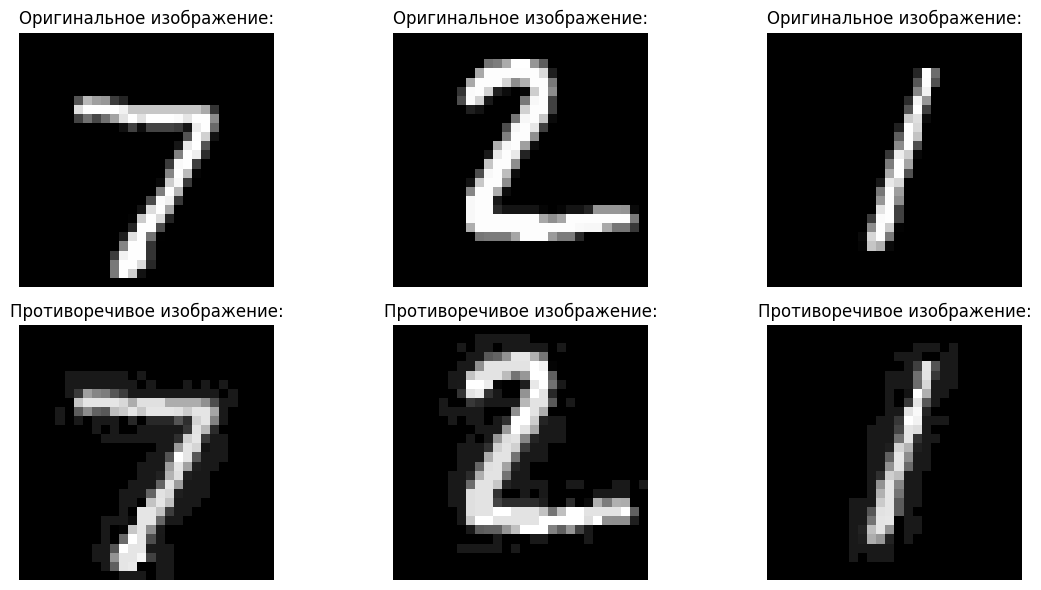

In [47]:
# Количество картинок для визуализации
NUM_EXAMPLES = 3

# Визуализация оригинальных и противоречивых изображений без использования функции
plt.figure(figsize=(12, 6))

for i in range(NUM_EXAMPLES):
    # Оригинальное изображение
    plt.subplot(2, NUM_EXAMPLES, i + 1)
    plt.imshow(test_images[i].reshape(28, 28), cmap='gray')
    plt.title(f"Оригинальное изображение:")
    plt.axis('off')

    # Противоречивое изображение
    plt.subplot(2, NUM_EXAMPLES, NUM_EXAMPLES + i + 1)
    plt.imshow(adversarial_images_model2[i], cmap='gray')
    plt.title("Противоречивое изображение:")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [52]:
# Оценим полносвязную модель на противоречивых примерах:
dense_model_loss, dense_model_accuracy = model1.evaluate(adversarial_images_model2.reshape(10000, 28, 28), test_labels)
# Оценим свёрточную модель на противоречивых примерах:
cnn_model_loss, cnn_model_accuracy = model2.evaluate(adversarial_images_model2.reshape(10000, 28, 28), test_labels)
print(f'Точность полносвязной модели: {dense_model_accuracy}')
print(f'Точность свёрточной модели: {cnn_model_accuracy}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9547 - loss: 0.1463
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7222 - loss: 1.1361
Точность полносвязной модели: 0.9575999975204468
Точность свёрточной модели: 0.7407000064849854


Вывод:Теперь наблюдается обратная картина: свёрточная модель показывает результат хуже, с точностью всего ~74%, тогда как полносвязная модель оказалась более устойчивой к атаке, потеряв лишь ~2% точности.

Атака FGSM между моделями переносится плохо

## Вывод
Результаты атак FGSM показывают, что влияние противоречивых примеров значительно различается в зависимости от архитектуры модели. Атака, направленная на полносвязную модель, снижает её точность до 95.76%, а точность свёрточной модели падает до 74.07%, что указывает на ограниченную переносимость атаки на свёрточную архитектуру. В случае атаки на свёрточную модель она сохраняет практически неизменную точность 96.11%, тогда как полносвязная модель становится крайне уязвимой, демонстрируя точность всего 11.48%. Это свидетельствует о том, что свёрточная модель обладает большей устойчивостью к атакам и способностью к обобщению, тогда как полносвязная модель более подвержена переносу атак. Данные результаты подчёркивают необходимость анализа устойчивости моделей и выбора оптимальной архитектуры для защиты от подобных воздействий.